# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 13, 16, 57, 59, 451497)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# os.environ["HOPSWORKS_API_KEY"] = open("../../data/hopsworks-api-key.txt", 'r').read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164449
2024-11-13 16:58:02,327 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()
model_version = 2
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=model_version,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4250517E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [59]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'])
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
7,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,stockholm
6,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,stockholm
0,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,stockholm
2,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,stockholm
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,stockholm
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,stockholm
8,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,stockholm
1,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,stockholm
3,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,stockholm


In [73]:
aq_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
date_before = today - datetime.timedelta(days = 3)
pm25_before = aq_fg.select(['date', 'pm25']).filter(aq_fg.date >= date_before).read().sort_values(by=['date'])

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


In [74]:
pm25_before

,date,pm25
1,2024-11-11 00:00:00+00:00,20.0
2,2024-11-12 00:00:00+00:00,21.0
0,2024-11-13 00:00:00+00:00,14.0


In [75]:
pm25_before = pm25_before['pm25'].tolist()

In [78]:
pm25_before 

[20.0, 21.0, 14.0]

In [79]:
predicted_pm25 = []
for index, row in batch_data.iterrows():
    row['pm25_1'] = pm25_before[2]
    row['pm25_2'] = pm25_before[1]
    row['pm25_3'] = pm25_before[0]
    pred = retrieved_xgboost_model.predict([row[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', \
                                                              'pm25_1', 'pm25_2', 'pm25_3']]])[0]
    predicted_pm25.append(pred)
    pm25_before.pop(0)
    pm25_before.append(pred)
print(predicted_pm25)

[16.371897, 21.275959, 19.38199, 17.278856, 18.946526, 26.166904, 25.239416, 35.43066, 16.089363]


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [82]:
if model_version == 2:
    batch_data['predicted_pm25'] = predicted_pm25
else:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
7,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,stockholm,16.371897
6,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,stockholm,21.275959
0,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,stockholm,19.381990
2,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,stockholm,17.278856
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,stockholm,18.946526
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,stockholm,26.166904
8,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,stockholm,25.239416
1,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,stockholm,35.430660
3,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,stockholm,16.089363


In [83]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 396.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [84]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
7,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,stockholm,16.371897,stockholm-st eriksgatan 83-air-quality,sweden,1
6,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,stockholm,21.275959,stockholm-st eriksgatan 83-air-quality,sweden,2
0,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,stockholm,19.381990,stockholm-st eriksgatan 83-air-quality,sweden,3
2,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,stockholm,17.278856,stockholm-st eriksgatan 83-air-quality,sweden,4
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,stockholm,18.946526,stockholm-st eriksgatan 83-air-quality,sweden,5
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,stockholm,26.166904,stockholm-st eriksgatan 83-air-quality,sweden,6
8,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,stockholm,25.239416,stockholm-st eriksgatan 83-air-quality,sweden,7
1,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,stockholm,35.430660,stockholm-st eriksgatan 83-air-quality,sweden,8
3,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,stockholm,16.089363,stockholm-st eriksgatan 83-air-quality,sweden,9


In [85]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-13 17:17:56,313 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



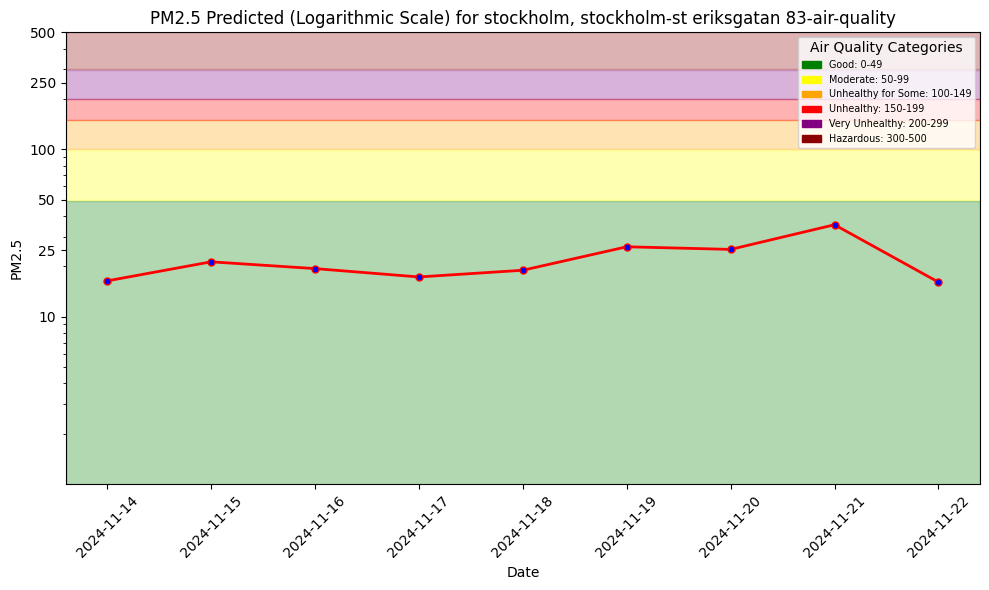

In [86]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [87]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [88]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164449/fs/1155152/fg/1346994


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164449/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f8c1c5067e0>, None)

In [89]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,6.0,0.0,15.124284,321.766113,stockholm,16.371897,stockholm-st eriksgatan 83-air-quality,sweden,1


In [90]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,pm25,country,city,street,url
0,2020-07-05 00:00:00+00:00,15.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
1,2018-12-25 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
2,2020-01-05 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
3,2024-03-26 00:00:00+00:00,21.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
4,2021-08-17 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...
2179,2018-06-16 00:00:00+00:00,28.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
2180,2020-09-18 00:00:00+00:00,15.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
2181,2023-12-04 00:00:00+00:00,19.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523
2182,2024-09-03 00:00:00+00:00,12.0,sweden,stockholm,stockholm-st eriksgatan 83-air-quality,https://api.waqi.info/feed/@10523


In [91]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


ValueError: feature_names mismatch: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_1', 'pm25_2', 'pm25_3'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_2, pm25_1, pm25_3 in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---